In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
# get utils for thresholds
from src import util_analysis 
from src import util_process_prolific as util_process
import importlib
from tqdm.auto import tqdm
import multiprocessing as mp

In [2]:
parent_dir = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
manifest = pd.read_pickle(parent_dir / "full_cue_target_distractor_df_w_meta_paths.pdpkl")

# Dev test for interaction between azimuth and elevation offset 

## Load participant data and meta files 

In [3]:
#############################
# Set file paths for data
#############################
parent_dir = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
manifest = pd.read_pickle(parent_dir / "full_cue_target_distractor_df_w_meta_paths.pdpkl")

################################
# Format transcript df 
################################
### Load in experiment manifests with full transcripts
path_to_manifest = Path('/om/user/imgriff/datasets/human_word_rec_SWC_2024/full_cue_target_distractor_df_w_meta_transcripts.pdpkl')
df_w_transcripts = pd.read_pickle(path_to_manifest)
df_w_transcripts['targ_src_stem'] = df_w_transcripts.excerpt_src_fn.apply(util_process.slice_transcript_path)

# unpack distractor words to individual columns
dist_1_word, dist_2_word = zip(*df_w_transcripts.distractor_word.apply(util_process.unpack_dist_words))

df_w_transcripts['distractor_1_word'] = dist_1_word
df_w_transcripts['distractor_2_word'] = dist_2_word
df_w_transcripts['targ_src_stem'] = df_w_transcripts.excerpt_src_fn.apply(util_process.slice_transcript_path)
df_w_transcripts['dist_1_src_stem'] = df_w_transcripts.excerpt_distractor_1_src_fn.apply(util_process.slice_transcript_path)
df_w_transcripts['dist_2_src_stem'] = df_w_transcripts.excerpt_distractor_2_src_fn.apply(util_process.slice_transcript_path)

def get_sex_cond(tgt_name, df_w_transcripts=df_w_transcripts):
    if tgt_name is None:
        return None
    return df_w_transcripts[df_w_transcripts["targ_src_stem"] == tgt_name].sex_cond.item()


out_dir = Path("final_results_dir")
path_to_parts = Path('/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/thresholds_v02')

part_results = sorted(list(path_to_parts.glob("*.csv")))

path_to_meta_data = Path('/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/speaker_array_manifests/thresholds_v02/')
meta_files = sorted(list(path_to_meta_data.glob("*meta.pkl")))

#################################
# Load in the transcripts
#################################
# meta_files
manifest_dict = {}
for meta_file in meta_files:
    if 'pilot' in meta_file.parent.stem:
        part_name = "pilot_" + "_".join(meta_file.stem.split('_')[:2])

    else:
        part_name = "_".join(meta_file.stem.split('_')[:2])
    manifest_dict[part_name] = meta_file

#################################
# Unbox human data
#################################

dfs = []
for result_file in part_results:
    part_name = result_file.stem
    part_ix = int(re.search(r'(\d+)', part_name).group())
    if part_ix > 33:
        continue
    if any(pilot_part_ix == part_ix for pilot_part_ix in [34, 35]):
        continue 

    # remove space 

    if 'pilot' in result_file.parent.stem:
        part_name = "pilot_" + "_".join(result_file.stem.split('_')[:2])
    if ' ' in part_name:
        part_name = part_name.split(' ')[0]
    # get digits in string pattern participant_xxx_ or participant_XXX. 
    part_ix = int(re.search(r'\d+', part_name).group())
    part_name_str = f"participant_{part_ix:03d}"
    manifest_file = manifest_dict[part_name_str]
    part_df = util_process.get_part_df(result_file)
    manifest_df = util_process.get_manifest_df(manifest_file)
    # merge on shared trial_index
    part_df = pd.merge(part_df[['trial_num', 'response', 'correct_response', 'correct']],
            manifest_df, left_on='trial_num', right_on='trial_num', how='left')
    part_df['participant'] = part_name_str
    part_df['tgt_name_stem'] = part_df['src_fn'].apply(lambda x: Path(x).stem)
    part_df['sex_cond'] = part_df['tgt_name_stem'].apply(get_sex_cond)

    dfs.append(part_df)

results_df = pd.concat(dfs, ignore_index=True)

## add transcripts for scoring 
results_df['dist_1_transcripts'] = [util_process.get_distractor_tscript(fname, df_w_transcripts) for fname in results_df.distractor_1_fn.to_list()]
results_df['dist_2_transcripts'] = [util_process.get_distractor_tscript(fname, df_w_transcripts) for fname in results_df.distractor_2_fn.to_list()]
results_df['target_transcripts'] = [util_process.get_target_transcript(fname, df_w_transcripts) for fname in results_df.src_fn.to_list()]

cols_to_score = ['response', 'target_word', 'distractor_1_word', 'distractor_2_word', 'target_transcripts', 'dist_1_transcripts', 'dist_2_transcripts']

## add confusions 
correct = []
confusions = []
for response, target_word, distractor_1_word, distractor_2_word, target_transcripts, dist_1_transcripts, dist_2_transcripts in results_df[cols_to_score].to_numpy():
    correct.append(int(response == target_word or response in target_transcripts))
    confusions.append(int(response in dist_1_transcripts or response in dist_2_transcripts or response in [distractor_1_word, distractor_2_word]))

results_df['correct'] = correct
results_df['confusions'] = confusions

#################################
# Summarize data per participant
#################################
## average over sex condition ehre 
grouped_part_results = results_df.groupby(['participant', 'target_azim', 'target_elev', 'azim_delta',  # 'sex_cond',
                                'elev_delta', 'snr', 'n_distractors',]).agg({'correct':['mean', 'sem'],
                                                                                'confusions':['mean', 'sem', 'count']}).reset_index()
# flatten multiindex
grouped_part_results.columns = ['_'.join(col).strip() for col in grouped_part_results.columns.values]
# remove trailing underscore
grouped_part_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_part_results.columns.values]

##################################
# Filter bad participants 
##################################
part_perf_avg = grouped_part_results.groupby('participant').correct_mean.mean()
# filter bad participants as those performing below the lower bound (mean - 2 SEM) seen in the online experiments with the same stimuli
cutoff = 0.3
good_parts = part_perf_avg[(part_perf_avg > cutoff)].index

good_part_results = grouped_part_results[grouped_part_results.participant.isin(good_parts)]

print(f"{good_part_results.participant.nunique()} participants above {cutoff} cutoff (out of {part_perf_avg.shape[0]} total)")


33 participants above 0.3 cutoff (out of 33 total)


In [5]:
good_part_results.to_csv('final_results_to_share/experiment_6_participant_results.csv', index=False)

<Figure size 640x480 with 0 Axes>

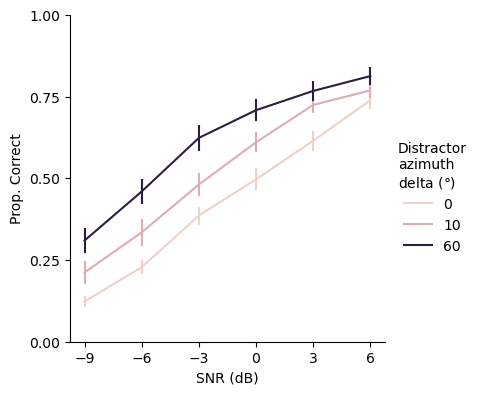

<Figure size 640x480 with 0 Axes>

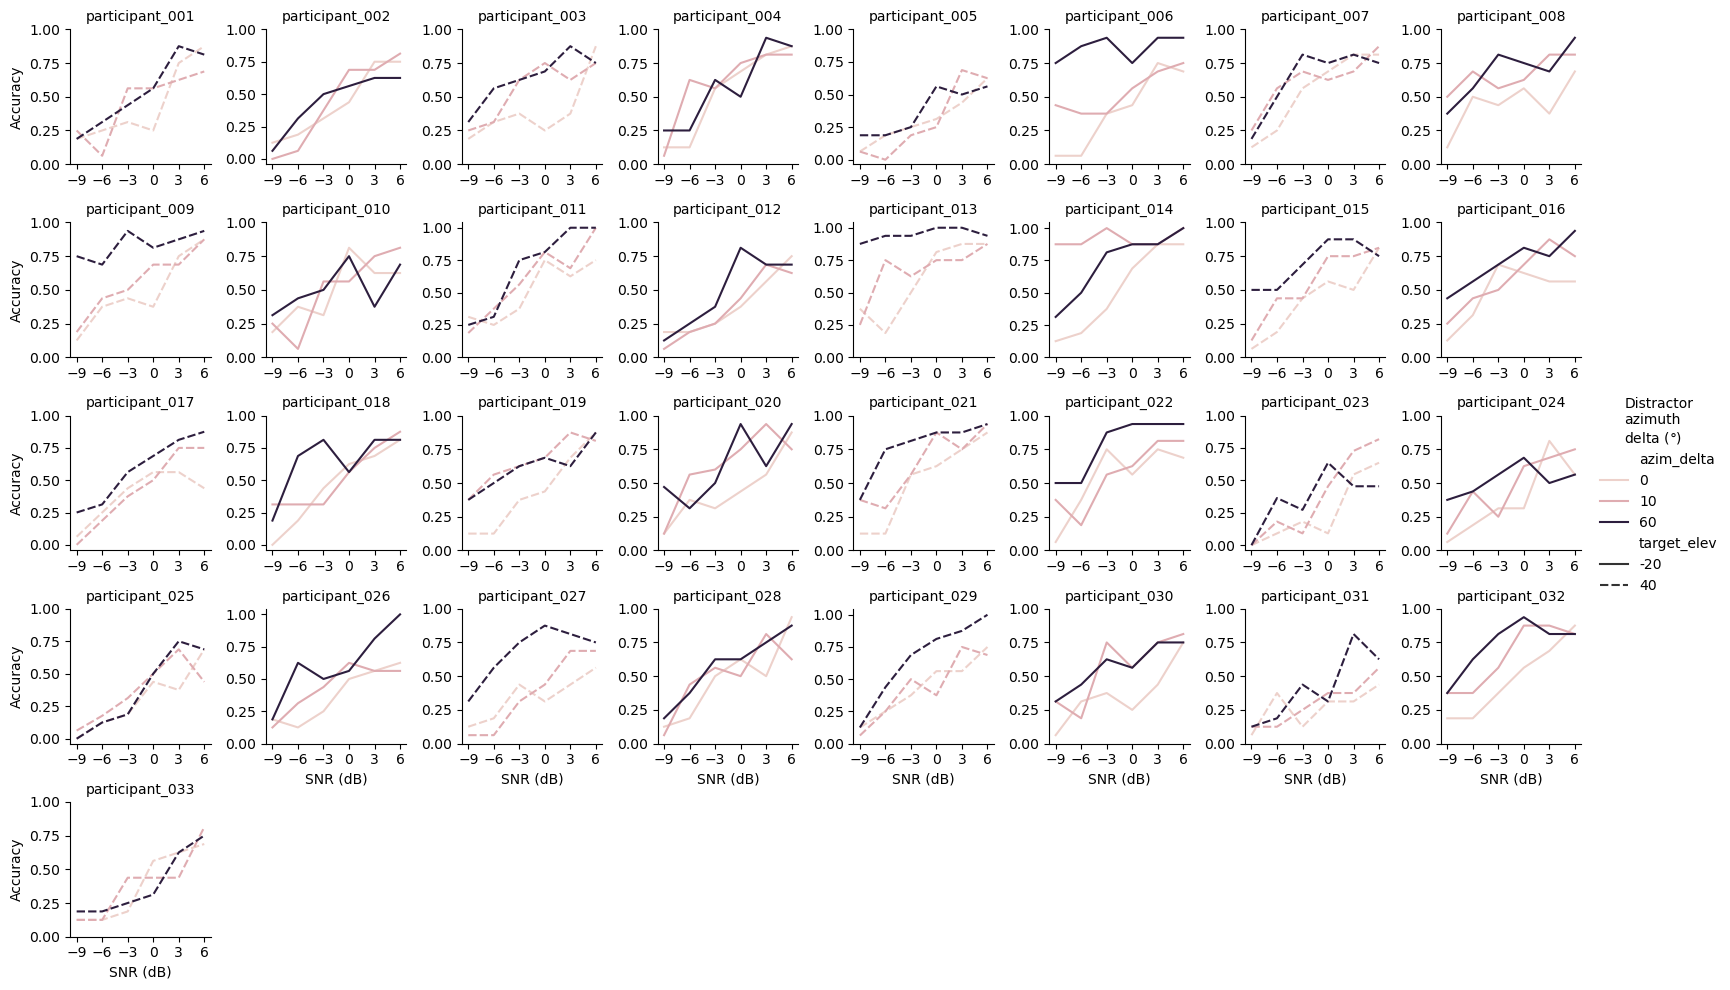

In [67]:
to_plot = good_part_results[
                            (good_part_results.n_distractors == 2)
                                    #   & (good_part_results.room_str == 'Min. reverb speaker array')
                                    # & (good_part_results.elev_delta.isin([0,10,60]))
                                    &	(good_part_results.elev_delta == 0) 
                                    # &	(good_part_results.target_elev != 0) 
                                & (good_part_results.azim_delta.abs().isin([0,10, 60]))
                                    #   & (good_part_results.snr.isin([6,3, 0, -3, -6, -9,]))
                                        ].copy()
plt.figure()
g = sns.relplot(data=to_plot,
                    x='snr', y='correct_mean', hue="azim_delta",
                    kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                    # col='sex_condition',
                    # row='target_elev',
                    # palette=palette, 
                    errorbar=('se', 1),
                    err_style='bars',
                    height=4, aspect=1)
g.set_axis_labels("SNR (dB)", "Prop. Correct")
# set legend title 
new_title = 'Distractor\nazimuth\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name} {row_name}")
# g.set(title=f'Azimuth trial performance')
plt.figure()
g = sns.relplot(data=to_plot,
                    x='snr', y='correct_mean', hue="azim_delta",
                    kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                    col='participant', col_wrap=8,
                    # row='room_str',
                    # palette=palette, 
                    style='target_elev',
                    errorbar=('se', 1),
                    err_style='bars',
                    height=2, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nazimuth\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)

<Figure size 640x480 with 0 Axes>

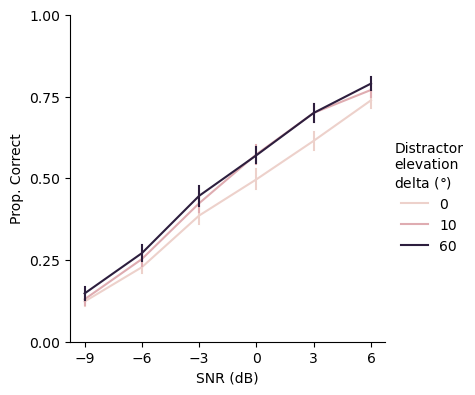

<Figure size 640x480 with 0 Axes>

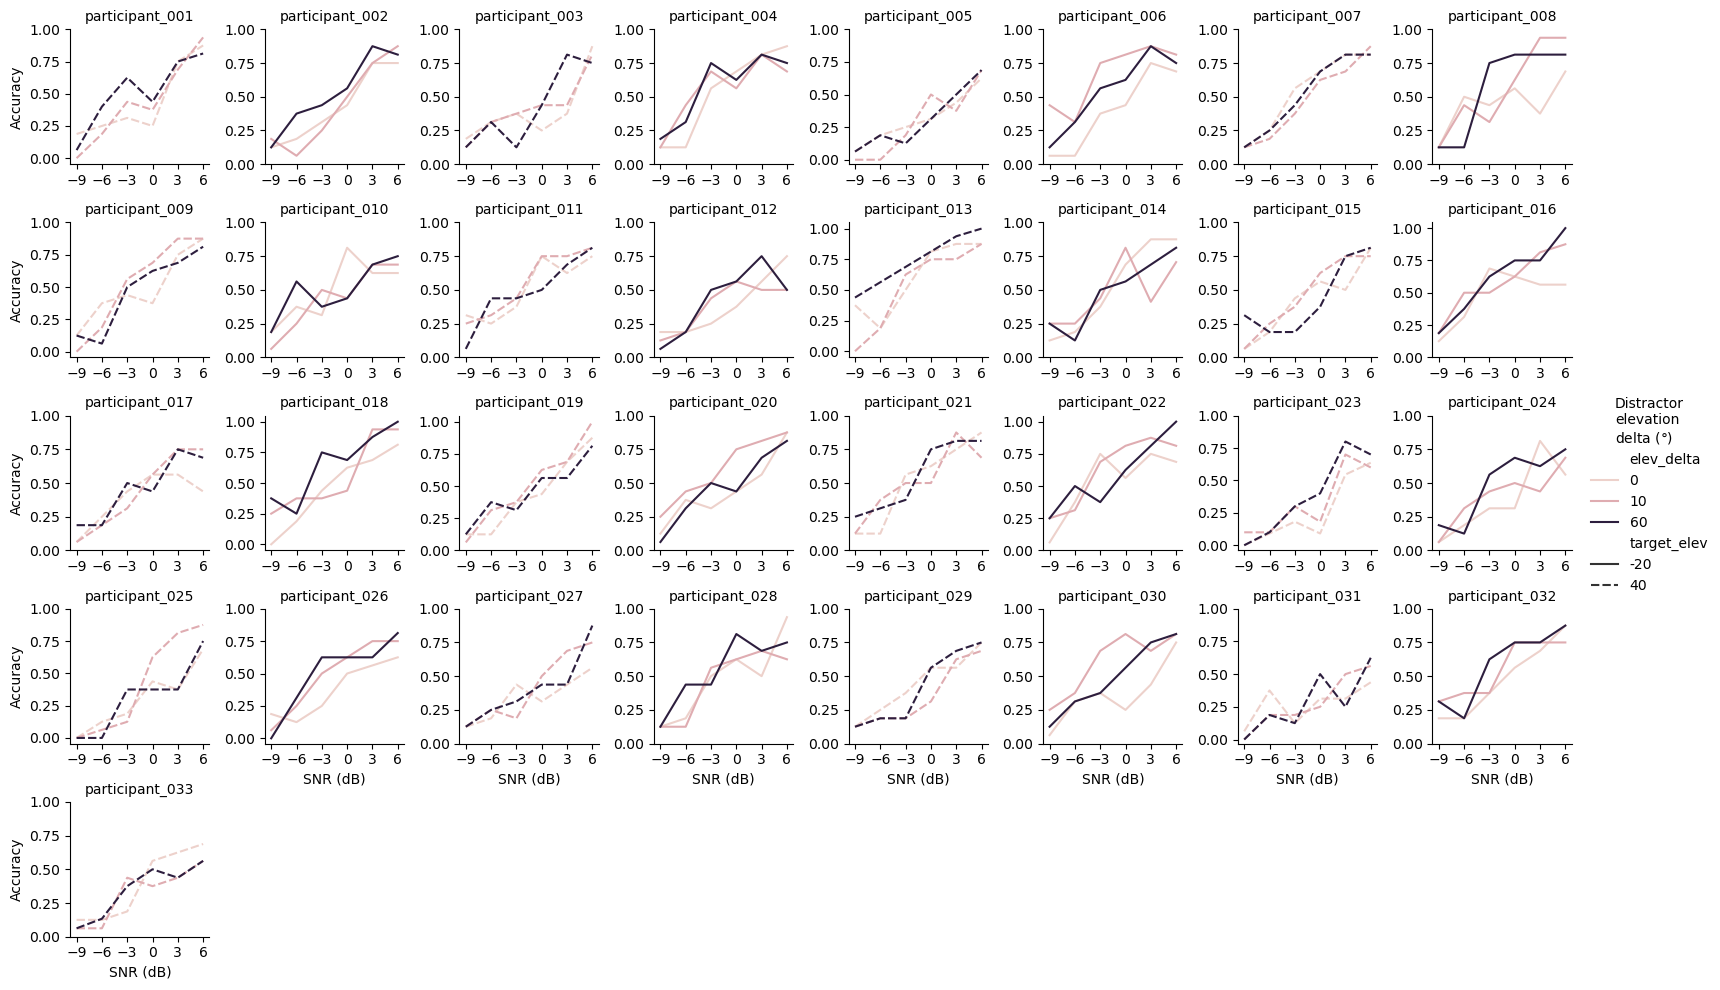

In [68]:
to_plot = good_part_results[
                                        (good_part_results.n_distractors == 2)
                                                #   & (good_part_results.room_str == 'Min. reverb speaker array')
                                                # & (good_part_results.elev_delta.isin([0,10,60]))
                                                &	(good_part_results.azim_delta == 0) 
                                                &	(good_part_results.target_elev != 0) 

                                                #   & (good_part_results.snr.isin([6,3, 0, -3, -6, -9,]))
                                                    ].copy()


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='correct_mean', hue="elev_delta",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                    # col='sex_condition',
                    # row='target_elev',                                # palette=palette, 
                                errorbar=('se', 1),
                                err_style='bars',
                                height=4, aspect=1)
g.set_axis_labels("SNR (dB)", "Prop. Correct")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set_titles("{col_name} ")

g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1], )#title='Elevation trial performance')
# column titles 
# g.set_titles("{col_name}")
# plt.suptitle(f, y=1.05)
plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='correct_mean', hue="elev_delta",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                                col='participant', col_wrap=8,
                                # row='room_str',
                                # palette=palette, 
                                style='target_elev',
                                errorbar=('se', 1),
                                err_style='bars',
                                height=2, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")


# Load pre-computed human threshold data

In [69]:
### 
path_to_human_results = Path('final_results_dir')

human_thresh_df = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_avg_sex_cond.pdpkl')

N = 33

human_thresh_df_summary = human_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']



## Compute stats for interaction manually

In Matlab code, using thresholds I eyeballed from the graph:

```...
threshold_data = ...
    [0 -1.6 -1.6;... %elevation
     0 -2.9 -6]; %azimuth

interaction_effects = threshold_data ...
    - mean(threshold_data,2)*ones(1,size(threshold_data,2)) ...
    - ones(size(threshold_data,1),1)*mean(threshold_data,1) ...
    + mean(threshold_data(:));

overall_interaction = sum(interaction_effects(:).^2);

In [70]:
human_thresh_df_summary

,elev_delta,azim_delta,threshold,threshold_std
0,0,0,0.059140,0.486347
1,0,10,-2.814872,0.635813
2,0,60,-5.495252,0.640000
3,10,0,-1.474366,0.462032
4,60,0,-1.585866,0.504760


In [71]:
threshold_data.mean(axis=0, keepdims=True), threshold_data.mean(axis=1, keepdims=True)

(array([[ 0.05913964, -2.14461937, -3.54055931]]),
 array([[-1.00036436],
        [-2.75032833]]))

In [72]:
elev_azim_means = threshold_data.mean(axis=1, keepdims=True) * np.ones((1, threshold_data.shape[1]))

In [73]:
offset_means = np.ones((threshold_data.shape[0], 1)) * threshold_data.mean(axis=0)

In [74]:
threshold_data - elev_azim_means - offset_means + threshold_data.mean(keepdims=True)

array([[-0.87498198, -0.20472898,  1.07971096],
       [ 0.87498198,  0.20472898, -1.07971096]])

In [75]:
# reformat array from summary: 
threshold_data = np.zeros((2,3))
threshold_data[0,:] = human_thresh_df_summary.loc[human_thresh_df_summary.azim_delta == 0, 'threshold'].values
threshold_data[1,:] = human_thresh_df_summary.loc[human_thresh_df_summary.elev_delta == 0, 'threshold'].values


# just use vectorized means for above 
interaction_effects = threshold_data \
                      - threshold_data.mean(axis=1, keepdims=True) \
                      - threshold_data.mean(axis=0, keepdims=True) \
                      + threshold_data.ravel().mean()
interaction_effects

overall_interaction = np.power(interaction_effects, 2).sum()
overall_interaction

3.9465663656922674

### Put in function for bootstrap over permutations 

In [76]:
def get_interaction(threshold_data, return_interaction=False):
    """
    Get the overall and unique interaction effects
    for a given threshold data matrix.

    Assumes rows map to elevation and azimuth conditions
    and columns map to the offset size. 

    Parameters
    ----------
    threshold_data : np.ndarray
        A 2D array of threshold data with shape (n_azim_elev, n_offset).
        The rows should be the elevation and azimuth conditions
        and the columns should be the offset size.
    Returns
    -------
    overall_interaction : float
        The overall interaction effect.
    interaction_effects : np.ndarray
        The unique interaction effects for each condition.
        Only returned if return_interaction is True.

    """
    # vectorized means used 
    # first mean is over rows (elevation and azimuth)
    # second mean is over columns (offset size)
    # third mean is over all elements
    interaction_effects = threshold_data \
                        - threshold_data.mean(axis=1, keepdims=True) \
                        - threshold_data.mean(axis=0, keepdims=True) \
                        + threshold_data.mean()
    

    overall_interaction = np.power(interaction_effects, 2).sum()

    if return_interaction:
        return overall_interaction, interaction_effects
    else:
        return overall_interaction


## Dev permutation test to get null distribution 

Proceedure per bootstrap:
1. permute both offset and azimuth elevation condition per participant
2. Obtain group-average thresholds using permuted data
3. measure interaction 

### Push participnat data into nD array for quick shuffling/manipulation

In [214]:
### For convenience, melt dataframe so offset size and direction are their own columns 

# break data out of dataframe, into 4D np array, where dim 1 is over participants, dim 2 is over azim and elev, 3 is SNR and 4 is the mean
part_data_for_permute = good_part_results[['participant', 'azim_delta', 'elev_delta', 'snr', 'correct_mean']].copy()

# get the unique  deltas - same for azimuth and elevation 
deltas = part_data_for_permute.azim_delta.unique() 
n_deltas = len(deltas)
n_participants = part_data_for_permute.participant.nunique()
snrs = part_data_for_permute.snr.unique()
n_snrs = part_data_for_permute.snr.nunique()
offset_dir_conds = 2 
dir_cond_map = {0:'azim_delta', 1:'elev_delta'}

part_data_array = np.zeros((n_participants, offset_dir_conds, n_deltas, n_snrs))

# loop over participants and fill in data array
for part_ix, participant in enumerate(part_data_for_permute.participant.unique()):
    # get the data for this participant
    part_data = part_data_for_permute[part_data_for_permute.participant == participant]
    for dir_ix, cond_str in dir_cond_map.items():
        # get the data for this direction
        if dir_ix == 0:
            alt_cond = dir_cond_map[1]
        elif dir_ix == 1:
            alt_cond = dir_cond_map[0]
        dir_data = part_data[part_data[cond_str].isin(deltas) & (part_data[alt_cond] == 0 )]

        for offset_ix, offset in enumerate(deltas):
            # get the data for this offset
            snr_vals = dir_data[dir_data[cond_str] == offset]
            # fill in the data array
            part_data_array[part_ix, dir_ix, offset_ix, :] = snr_vals.correct_mean.values



## Set up bootstrap

In [ ]:
np.random.seed(0)
rng = np.random.default_rng(0)
n_boots = 10_000  ## use 10_000 for final analysis

N = good_part_results.participant.nunique()
null_interactions = np.zeros((n_boots))

for i in tqdm(range(n_boots)):
    # shuffle data within participants - vectorized approach 
    shuffled_data = rng.permuted(part_data_array, axis=1)
    shuffled_data = rng.permuted(shuffled_data, axis=2)
    # mean over participants post shuffling 
    shuffled_mean = shuffled_data.mean(axis=0)
    # init_threshold data array for this permutation  
    thresh_data_array = np.zeros((2, 3))
    for dir_cond_ix, cond_str in dir_cond_map.items():
        for offset_ix, offset in enumerate(deltas):
            # get the data for this offset
            snr_vals = shuffled_mean[dir_cond_ix, offset_ix]
            # get threshold for this condition
            thresh, _ = util_analysis.estimate_threshold_poly(snrs, snr_vals, degree=2)
            thresh_data_array[dir_cond_ix, offset_ix] = thresh
    null_interactions[i] = get_interaction(thresh_data_array, return_interaction=False)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [264]:
## Get p value from null_intarctions and overall interaction

(np.abs(null_interactions) > np.abs(overall_interaction)).mean()

0.0

Text(0.5, 0, 'Interaction statistic')

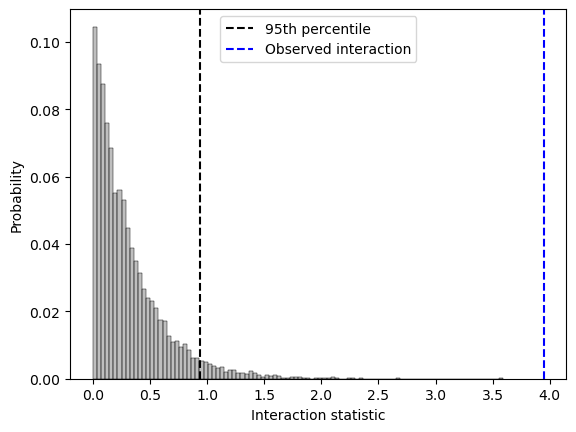

In [288]:
# get 95% percentile from null interactions 

sig_level = np.percentile(null_interactions, 95)

# sns.histplot(data, bins=30, stat='probability')

sns.histplot(null_interactions, bins=100, stat='probability', alpha=0.5, color='gray',);
# add vertical line to plot for actual interaction value 
plt.axvline(sig_level, color='k', linestyle='--', label='95th percentile')
plt.axvline(overall_interaction, color='blue', linestyle='--', label='Observed interaction')
plt.legend()
plt.xlabel('Interaction statistic')
# plt.(overall_interaction, color='red', linestyle='--')